In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import os
from itertools import count

In [4]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split
import cv2
import seaborn as sns

In [5]:
from sklearn.metrics import confusion_matrix,multilabel_confusion_matrix
from sklearn.metrics import accuracy_score

In [6]:
train_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/train_set.csv', index_col="Id")
labels = train_df.columns
train_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/img/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
train_df["seg"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2022/train/seg/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
print("The training set contains {} examples.".format(len(train_df)))

The training set contains 749 examples.


In [7]:
#Consider lowering the image size for testing purposes...

IMG_SIZE = [256,256]
train_df['img'] = train_df['img'].apply(lambda img: cv2.resize(img,IMG_SIZE))
train_df['seg'] = train_df['seg'].apply(lambda img: cv2.resize(img,IMG_SIZE))

In [8]:
# Split 20% off for the test data
train_data, test_data = train_test_split(train_df,test_size = 0.2,shuffle=True,random_state = 0)
# Split 25% off the train data to use as validation (0.25 x 0.8 = 0.2)
train_data, val_data = train_test_split(train_data,test_size = 0.25,shuffle=True,random_state = 1)
print(f" Ntrain {len(train_data.index)}")
print(f" Ntest  {len(test_data.index)}")
print(f" Nval   {len(val_data.index)}")


 Ntrain 449
 Ntest  150
 Nval   150


In [9]:
def extractImgSegCat(df):
    img = np.stack( df["img"], axis=0 )
    seg = np.stack( df["seg"], axis=0 )
    cat = df.drop(labels=['img','seg'],axis=1 )
    return img,seg,cat

Ximg_train,ySeg_train,yCat_train = extractImgSegCat(train_data)
Ximg_test ,ySeg_test ,yCat_test  = extractImgSegCat(test_data)
Ximg_val  ,ySeg_val  ,yCat_val   = extractImgSegCat(val_data)

In [67]:
#y_dec_train = yCat_train
#y_dec_train = np.where(y_dec_train ==1, 0, 1)

#y_dec_val = yCat_val
#y_dec_val = np.where(y_dec_val ==1, 0, 1)

In [12]:
x_train = Ximg_train / 255.
x_val = Ximg_val / 255.
x_test = Ximg_test / 255.

# Adversarial attack

Several methods exist for adversarial attacks. In essence the simplest one is the fast sign gradient method. All it needs is for a cost function to be specified, afterwards the output of the model can be taken as input to an objective function. That allows the gradients to be computed with respect to the original image. Afterwards any first or second order optimisation method can be used, e.g. gradient descent with momentum to produce noise that misclassifies an image. [Goodfellow, I. J., Shlens, J., & Szegedy, C. (2014). Explaining and harnessing adversarial examples. arXiv preprint arXiv:1412.6572.](https://arxiv.org/abs/1412.6572)

FGSM has two weakness though:

1. The procedure needs to be repeated for each image. This is what is meant with the **iterative** nature of this attack.
2. The procedure is quite slow.

In this section we propose a procedure that is heavily inspired by both the project brief and a recent paper. [Poursaeed, O., Katsman, I., Gao, B., & Belongie, S. (2018). Generative adversarial perturbations. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (pp. 4422-4431).](https://openaccess.thecvf.com/content_cvpr_2018/papers/Poursaeed_Generative_Adversarial_Perturbations_CVPR_2018_paper.pdf)

On a high level the procedure goes as follows:

* Step 0: The classifier. We train a classifier and/or segmentation model that we will attack. We chose to attack our Xception based classifier. We will not cover a detailed explanation of the model as this is already covered above.
* Step 1: Training the Convolutional Autoencoder
* Step 2: Defining the loss function and reguralisation term
* step 3: Defining the task and the pipeline
* Step 4: Evaluation

In [ ]:
classifier = keras.models.load_model('../input/classifier/classifier_adv.h5')

## Step 1: The Convolutional Autoencoder

### Key principles

Autoencoders are a type of machine learning algorithm that are capable of compressing input. They function by taking an input and gradually shinking it until a so called information bottleneck. Afterwards the input is expanded from the bottleneck onwards while trying to minimise the reconstruction loss, the difference between the input and the output.

We use autoencoders to move from the iterative procedure to a **generative** approach. Although autoencoders are not considered generative models we could use them to produce image dependent noise to influence the classifiers. After this procedure is carried out, the idea is that given an input image the autoencoder can produce a specific pattern that lets the image be misclassified. 

**In our approach we train the autoencoder separately. Freeze the encoder and apply transfer learning on the decoder.** The idea is that first a latent representation is learnt of the input. We then ask it to produce noise based on this latent representation. The stagewise approach of training the autoencoder also simplifies the attack.


### Our chosen architecture

The chosen architecture of the autoencoder had inspiration from three main sources:

1. A 2014 paper on Convolutional neural network architectures that covers the fact that CNN's can entirely be built out of convolutional layers. [Springenberg, J. T., Dosovitskiy, A., Brox, T., & Riedmiller, M. (2014). Striving for simplicity: The all convolutional net. arXiv preprint arXiv:1412.6806.](https://arxiv.org/abs/1412.6806)
2. The UNET architecture as described in the previous sections.
3. [A lecture of the University of Amsterdam on convolutional autoencoders.](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html)

Our main goal was keeping the architecture as simple as possible. The first paper gave us insight into how we could do that. The intuition behind convolutional neural networks is that throughout the network the resolution of the image is reduced, while the amount of (hierarcical) features is increase incrementally. In the first layer the neurons look for gabor-like features (cfr. the lectures) and in higher levels these are combined. **Resolution reduction usually happens with max or average pooling. In our architecture we do it with stride convolutions.** The idea behind strided convolutions, not to be confused with dilated convolutions, is that only half of the image is convolved around. By adding the correct amount of padding this operation can be used to exactly halve the size of the input image. For reference, we used the following formula:

![](https://i.stack.imgur.com/vD1u3.png)
 
Afterwards the used UNET as a source of inspiration as to how to arrange the convolutions. We group them in blocks of three where the first one is a strided convolution. The following two are are same convolutions. Afterwards the resolution is dropped again. **The input image is iteratively reduced from 256 x 256 x 3 to 32 x 32 x 64 in the information bottle neck which represent a compression ratio of 2/3rd.**

The decoder has exactly the same architecture, but with strided transposed convolution operations. With these the inputs are doubled while going through the network. Between each of these two same convolutions are applied. In the final layer a sigmoid activation function is used to ensure that the output is bound between 0 and 1..

**Batch normalization is used together with a LeakyRelu activation function to smoothen the procedure of training.** The network can be trained with either the mean squared error or binary cross entropy as an objective function. We received better performance while training with BCE. **More complex architectures such as skip connections between the same convolutions were also considered but did not result in better performance.** Autoencoders can leverage existing ideas from architectures such as Resnet or Xception. We chose to keep the architecture simple as it already provided reasonable results.
 
All things considered this results in a network that has around 450.000 parameters.

In [ ]:
classifier = keras.models.load_model('../input/classifier/classifier_adv.h5')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder (Sequential)         (None, 32, 32, 64)        224448    
_________________________________________________________________
decoder (Sequential)         (None, 256, 256, 3)       251951    
_________________________________________________________________
tf.math.sigmoid_1 (TFOpLambd (None, 256, 256, 3)       0         
Total params: 476,399
Trainable params: 474,537
Non-trainable params: 1,862
_________________________________________________________________
Epoch 1/250
29/29 [==============================] - 6s 159ms/step - loss: 0.6322 - accuracy: 0.3604 - val_loss: 0.6759 - val_accuracy: 0.2543
Epoch 2/250
29/29 [==============================] - 4s 123ms/step - loss: 0.5694 - accuracy: 0.4263 - v

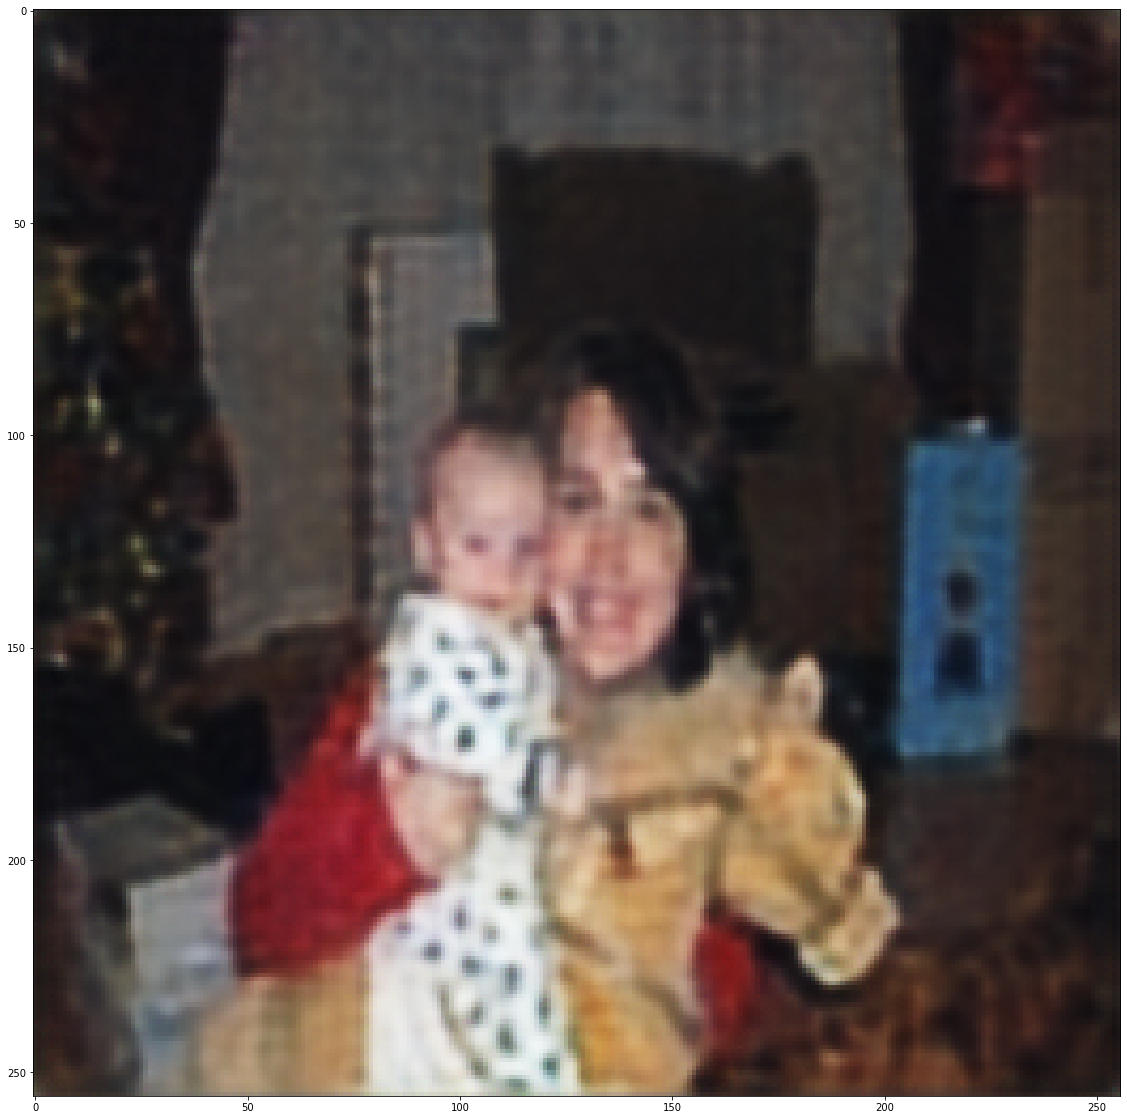

In [70]:
class ConvAutoEncoder(keras.Model):
    def __init__(self, KernelSize=(3,3), act_fn= keras.layers.LeakyReLU, name="Autoencoder"):
        super(ConvAutoEncoder, self).__init__(name=name)        
        
        self.encoder = keras.Sequential([
                                        keras.layers.Conv2D(32, kernel_size = KernelSize, strides=(2,2), padding="same"),
                                        keras.layers.BatchNormalization(),
                                        act_fn(),
            
                                        keras.layers.Conv2D(32, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                        keras.layers.BatchNormalization(),
                                        act_fn(),
            
                                        keras.layers.Conv2D(32, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                        keras.layers.BatchNormalization(),
                                        act_fn(),
        
        
                                        keras.layers.Conv2D(64, kernel_size = KernelSize, strides=(2,2), padding="same"),
                                        keras.layers.BatchNormalization(),
                                        act_fn(),
            
                                        keras.layers.Conv2D(64, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                        keras.layers.BatchNormalization(),
                                        act_fn(),
            
                                        keras.layers.Conv2D(64, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                        keras.layers.BatchNormalization(),
                                        act_fn(),
            
        
                                        keras.layers.Conv2D(64, kernel_size = KernelSize, strides=(2,2), padding="same"),
                                        keras.layers.BatchNormalization(),
                                        act_fn(),
            
                                        keras.layers.Conv2D(64, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                        keras.layers.BatchNormalization(),
                                        act_fn(),
            
                                        keras.layers.Conv2D(64, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                        keras.layers.BatchNormalization(),
                                        act_fn(),], name="encoder") # 32 x 32 x 64 => 1/3
        
        
        
        
        self.decoder = keras.Sequential([
                                    keras.layers.Conv2DTranspose(64, kernel_size = KernelSize, strides=(2,2), padding="same"),
                                    keras.layers.BatchNormalization(),
                                    act_fn(),

                                    keras.layers.Conv2D(64, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                    keras.layers.BatchNormalization(),
                                    act_fn(),
            

                                    keras.layers.Conv2D(64, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                    keras.layers.BatchNormalization(),
                                    act_fn(),
            
                                    keras.layers.Conv2DTranspose(64, kernel_size = KernelSize, strides=(2,2), padding="same"),
                                    keras.layers.BatchNormalization(),
                                    act_fn(),
            

                                    keras.layers.Conv2D(64, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                    keras.layers.BatchNormalization(),
                                    act_fn(),

                                    keras.layers.Conv2D(64, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                    keras.layers.BatchNormalization(),
                                    act_fn(),
            
                                    keras.layers.Conv2DTranspose(32, kernel_size = KernelSize, strides=(2,2), padding="same"),
                                    keras.layers.BatchNormalization(),
                                    act_fn(),
            

                                    keras.layers.Conv2D(32, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                    keras.layers.BatchNormalization(),
                                    act_fn(),

                                    keras.layers.Conv2D(3, kernel_size = KernelSize, strides=(1,1), padding="same"),
                                    keras.layers.BatchNormalization()
                                    ], name = "decoder")
                

        
    def call(self, inputs):
        x = self.encoder(inputs)
        x = self.decoder(x)
        return keras.activations.sigmoid(x)
    
    def build_graph(self, raw_shape):
        x = tf.keras.layers.Input(raw_shape)
        return tf.keras.Model(inputs=[x], 
                                  outputs=self.call(x))


autoencoder = ConvAutoEncoder()
autoencoder.build_graph(IMG_SIZE+[3]).summary()

autoencoder.compile(
          optimizer=keras.optimizers.Adam(learning_rate = 3e-4),
          loss=keras.losses.BinaryCrossentropy(),
          metrics= ['accuracy'])

# autoencoder.fit(x_train, x_train,
#                 batch_size= 16,
#                             epochs=250, verbose=1,
#                             validation_data=(x_val,x_val),
#                             callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

# autoencoder.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
#               loss=keras.losses.BinaryCrossentropy(),
#               metrics=['accuracy'])
# autoencoder.summary()

# history = autoencoder.fit(np.vstack([x_train, x_val]), np.vstack([x_train,x_val]),
#                             batch_size= 32,
#                             epochs=10, verbose=1)

autoencoder = keras.models.load_model("../input/adversarialattack/autoencoder.tf")
images = autoencoder.predict(x_val)
plt.imshow(images[0])

## Step 2: Defining the loss function and reguralisation term

### The loss function

Conceptually the loss function is something of the form: 
$$ \min L + \lambda * \lVert Noise \rVert $$

with $L$ being $MSE$ or $BCE$. This opens three additional questions: 

1. What loss function will be used?
2. What vector norm will be used?
3. How do we set $\lambda$?


#### BCE VS MSE

We tried out both $BCE$ and $MSE$ but the former gave empirically better results. Mean squared error did not work as well.

#### The vector norm

The $L_{2}$ norm produced the best resutls for us, however we understand the difference that both vector norms encode. The $L_{\infty}$ should 'punish' large magnitude noise. That makes intuitive sense as the pieces of noise we should perceive the most are high intensities when summing over the three channels. We however produced the best results when using the $L_{2}$ norm.


#### Setting lambda

$\lambda$ modulates how much weight is given to either classifying the deceptive labels or reducing the amount of noise added to the image. **We used the following simple heuristic to tune how much it should be set to:**

$$ \lambda = \frac{1}{W * H * channels} $$

The intuition behind the heuristic is that both $MSE$ and $BCE$ are spaced between 0 and 1. With the transformation outlined above if all pixels channels are set to one the resulting $L_{2} = 256 * 256 * 3$ and when multiplied by $\lambda = 5.0862630208333333333333333333333e^{-6}$ it equals 1. **This ensures that both the $L$ and the $R$ term are on the same scale. This number can be tuned with a hyperparameter search but we deemed this out of scope for this assignment.**

In [18]:
class NoiseReguralisation(keras.layers.Layer):
    
    def __init__(self, rate=0.5): # Rate is lambda
        super(NoiseReguralisation, self).__init__()
        self.rate = rate

    def call(self, inputs):
        self.add_loss(self.rate * tf.reduce_sum(tf.square(inputs)))
        return inputs

## Defining the task and pipeline

### The task: making aeroplanes appear where they are not

We do this by handing the model one vector called $y_dec$ and having it minimise the loss function as explained previously with respect to that. We essentially ask the model to keep correctly classifying images as aeroplanes when they are not and to classify non-aeroplanes as aeroplanes. The second term in the loss function forces the model to do this by introducing as little noise as possible. This also means that $distance(image_{original}, image_{peturbed})$ is minimal. 

In [ ]:
y_dec_train = np.ones(yCat_train.shape[0])
y_dec_val = np.ones(yCat_val.shape[0])

### The model

**For our attack we first trained a classifier and an autoencoder separately. Afterwards we froze the classifier and the encoder. During training we simply update the decoder to produce the specific noise we want**

This procedure ensures that only 250000 parameters need to be updated. **Since this is a whitebox attack we can benefit from simply computing the gradient after the classifier and using backpropagation through the classifier into the decoder.** In essence, this is a form of transfer learning, the decoder is re-trained to output the noise necessary to fool a classifier. The code below shows how the procedure is done. Training this procedure can take upwards of 200-300 epochs. The first few epochs have a high loss and are most likely spent reducing the output of the autoencoder. It's advisable to train this network with early stopping.

The procedure described is somewhat similar to [Poursaeed, O., Katsman, I., Gao, B., & Belongie, S. (2018). Generative adversarial perturbations. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (pp. 4422-4431).](https://openaccess.thecvf.com/content_cvpr_2018/html/Poursaeed_Generative_Adversarial_Perturbations_CVPR_2018_paper.html) however there are noticeable differences between our approach and theirs. The training procedures is noticeably different, they do not have a reguralisation term in the loss function but rather use scaling and clipping. **It is important to note that their approach also results in human visible peturbations.**


In [57]:
class AdversarialAttack(keras.Model):
    def __init__(self, classifier, autoencoder, attacked_class, rate, name="AdversarialAttack"):
        super(AdversarialAttack, self).__init__(name=name)
        
        self.classifier = classifier
        self.autoencoder = autoencoder
        self.attacked_class = attacked_class
        self.noiseReguralisation = NoiseReguralisation(rate)
        
        self.classifier.trainable = False
        self.autoencoder.get_layer(name="encoder").trainable = False
       
    
    def call(self, inputs):
        original_images = inputs
        x = self.autoencoder(inputs)
        x = self.noiseReguralisation(x)
        x = keras.layers.Add()([x, original_images])
        x =  self.classifier(x)[:,self.attacked_class]
        return x
    
    def return_noise(self, inputs):
        return self.autoencoder.predict(inputs)
    
    def return_attacker(self):
        return self.autoencoder
    
    def build_graph(self, raw_shape):
        x = tf.keras.layers.Input(raw_shape)
        return tf.keras.Model(inputs=[x], 
                                  outputs=self.call(x))
    

attacker = AdversarialAttack(classifier, autoencoder, 0, 5.0862630208333333333333333333333e-6)

attacker.build_graph(IMG_SIZE+[3]).summary()
attacker.compile(optimizer=keras.optimizers.Adam(learning_rate = 3e-4),
          loss=keras.losses.BinaryCrossentropy())

attacker_weights = keras.models.load_model("../input/adversarialattack/adversarial.tf")

attacker.set_weights(attacker_weights.get_weights())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Autoencoder (ConvAutoEncoder)   (None, 256, 256, 3)  476399      input_5[0][0]                    
__________________________________________________________________________________________________
noise_reguralisation_4 (NoiseRe (None, 256, 256, 3)  0           Autoencoder[4][0]                
__________________________________________________________________________________________________
add_4 (Add)                     (None, 256, 256, 3)  0           noise_reguralisation_4[0][0]     
                                                                 input_5[0][0]              

In [34]:
# attacker.fit(x_train, y_dec_train,
#                 batch_size= 16,
#                             epochs=250, verbose=1,
#                             validation_data=(x_val,y_dec_val),
#                             callbacks=[tf.keras.callbacks.EarlyStopping(patience=25)])

Epoch 1/250
29/29 [==============================] - 7s 251ms/step - loss: 0.3983 - val_loss: 0.4034
Epoch 2/250
29/29 [==============================] - 7s 245ms/step - loss: 0.3666 - val_loss: 0.5428
Epoch 3/250
29/29 [==============================] - 8s 265ms/step - loss: 0.3278 - val_loss: 0.6089
Epoch 4/250
29/29 [==============================] - 8s 265ms/step - loss: 0.3307 - val_loss: 0.3983
Epoch 5/250
29/29 [==============================] - 8s 265ms/step - loss: 0.3412 - val_loss: 0.3962
Epoch 6/250
29/29 [==============================] - 7s 245ms/step - loss: 0.3513 - val_loss: 0.5320
Epoch 7/250
29/29 [==============================] - 8s 264ms/step - loss: 0.3130 - val_loss: 0.6185
Epoch 8/250
29/29 [==============================] - 8s 264ms/step - loss: 0.3381 - val_loss: 0.4640
Epoch 9/250
29/29 [==============================] - 8s 264ms/step - loss: 0.3315 - val_loss: 0.7865
Epoch 10/250
29/29 [==============================] - 7s 246ms/step - loss: 0.3064 - val_lo

In [66]:
noise = attacker.return_noise(x_val)

In [23]:
plt.rcParams['figure.figsize'] = [20, 20]

## Results

As you can see below the perturbations are human visible. **It is important to note that continuing training with a smaller learning rate and/or tuning $\lambda$ might both lead to less visible noise**.

The attack is not so realistic as the amount of noise added can clearly be seen by someone. Secondly, we had white-box access to the model which is very rare. We do not expect such scenario's to occur frequently.

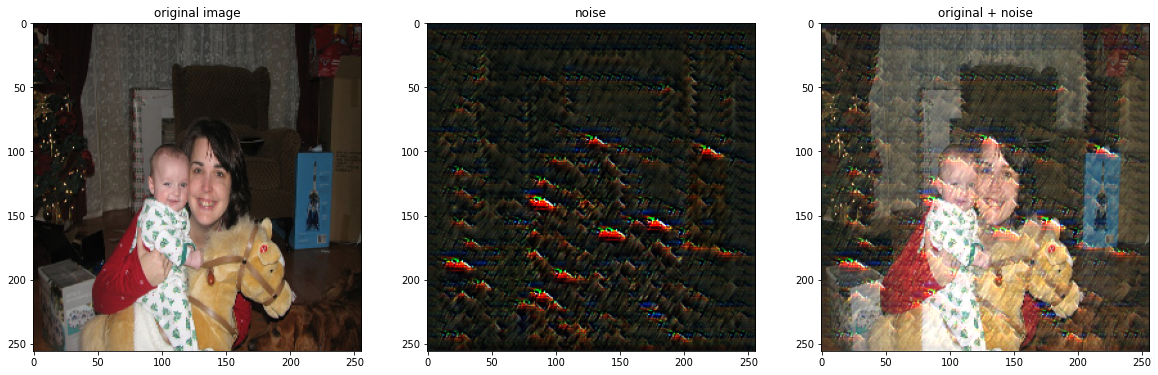

In [59]:
def plot_example(index):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)


    ax1.set_title("original image")
    ax1.imshow(x_val[index])  
    ax2.set_title("noise")

    ax2.imshow(noise[index])
    ax3.set_title("original + noise")

    ax3.imshow(x_val[index] + noise[index]) 

plot_example(0)

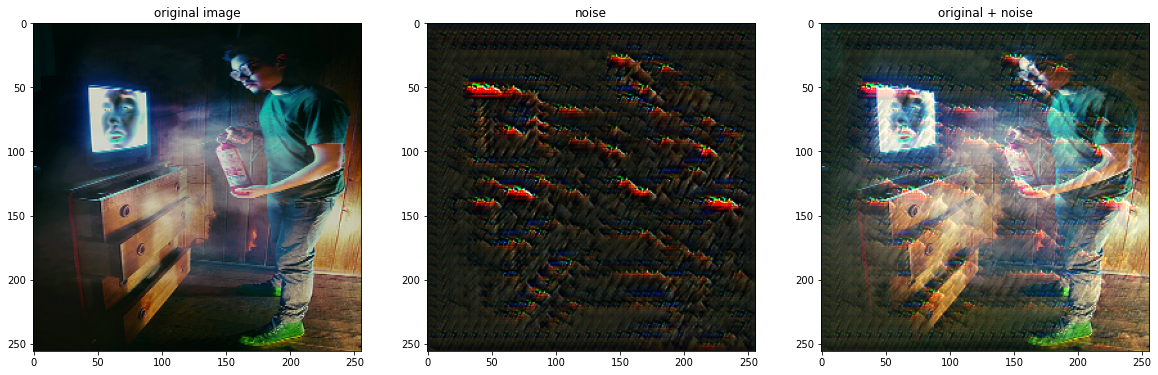

In [36]:
plot_example(10)

In the image below a confusion matrix between the testing set and the attacker are shown. **This indicates that the model is able to attack images it was not trained on. Only 8 images were not classified as aeroplanes on the hold-out set.** This strongly implies this attack can be carried out on random images as well. 

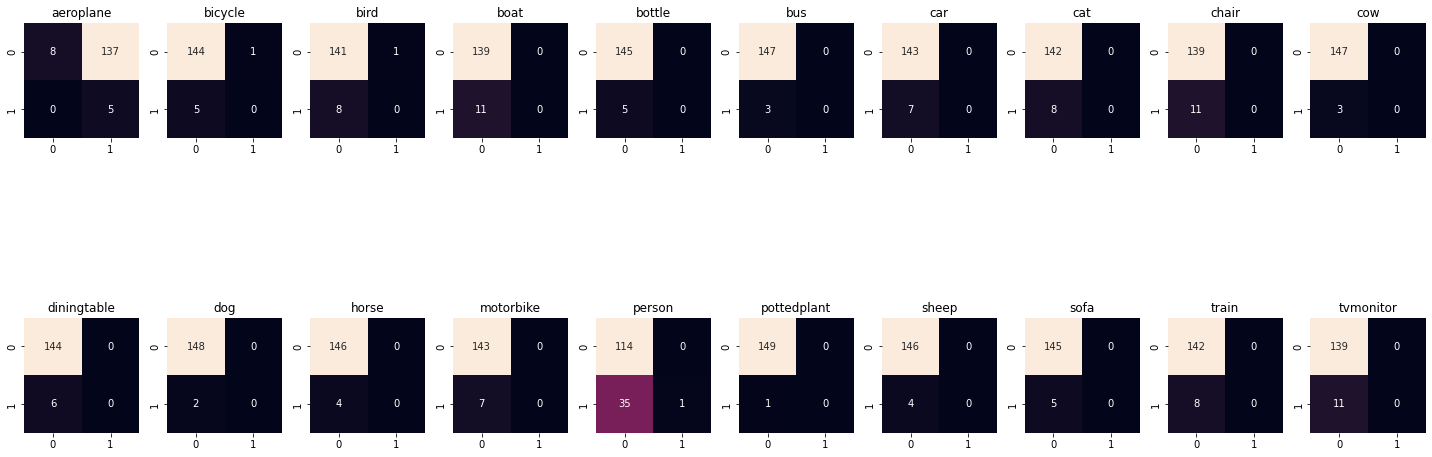

In [60]:
noise_test = attacker.return_noise(x_test)
y_test = classifier.predict(x_test)
y_test = y_test.round()
noisy_predictions = classifier.predict(x_test + noise_test)
noisy_predictions = noisy_predictions.round()

CM = multilabel_confusion_matrix(y_test, noisy_predictions)

labels = yCat_test.columns

fig = plt.figure(figsize=(20,10))
ax = fig.subplots(2,10)
ax = ax.flatten()
for l,c,a in zip(labels,CM,ax):
    sns.heatmap(c, annot=True,ax=a,cbar=False,fmt="g") # font size\
    a.set_title(l)
    a.set_aspect('equal', 'box')

plt.tight_layout()

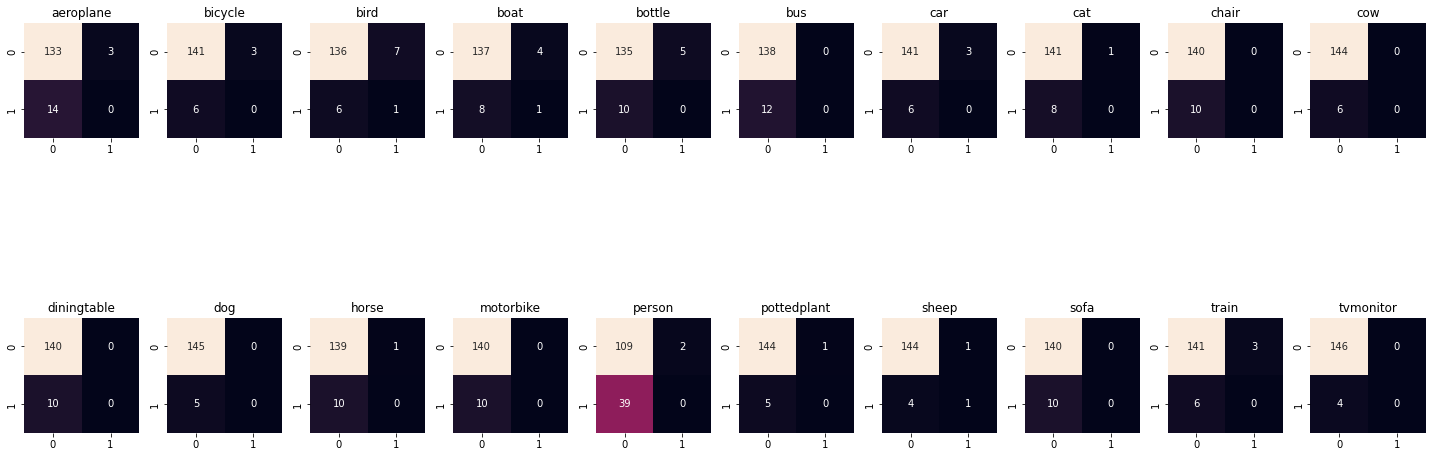

In [91]:
noise_val = attacker.return_noise(x_val)
y_val = classifier.predict(x_val)
y_val = y_val.round()
adv_val = classifier.predict(x_val + noise_val)
adv_val = noisy_predictions.round()

CM = multilabel_confusion_matrix(y_val, adv_val)

labels = yCat_test.columns

fig = plt.figure(figsize=(20,10))
ax = fig.subplots(2,10)
ax = ax.flatten()
for l,c,a in zip(labels,CM,ax):
    sns.heatmap(c, annot=True,ax=a,cbar=False,fmt="g") # font size\
    a.set_title(l)
    a.set_aspect('equal', 'box')

plt.tight_layout()

The following indicates that only in four cases in the validation set the classifier was able to tell the image was not an aeroplane. In all other cases the classifier was fooled by the adversary.

In [27]:
adversarial_labels = attacker.predict(x_val)
adversarial_labels = adversarial_labels.round()
adversarial_labels

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [84]:
yCat_val.iloc[:,0].to_numpy() ### Actual labels

array([1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0])